In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


基本変数定義

In [2]:
sampling_flg=0 #サンプリング有無をコントロール
submit_flg=1 #保存するかをコントロール（サンプリングしない時のみ）

SEED=12345
sample_num=10000
fold_num=5

#train関連
train_dir='../../02_feature/101_train.csv'
train_drop_col=['ID_code', 'target']
train_label='target'

#test関連
test_dir='../../02_feature/101_test.csv'
test_drop_col=['ID_code']

#結果ファイル関連　nameは自分の名前に変更する
train_preds_dir='../../03_predict_train/oka_243_LightGBM_train.csv'
test_preds_dir='../../04_predict_test/oka_243_LightGBM_submission.csv'
save_col_name='oof_xgb'

sample_submission_dir='../../01_input/sample_submission.csv'
submission_target_col_name='target'
submission_id_col_name='ID_code'

前処理

In [3]:
#ロード
train_df=pd.read_csv(train_dir)
test_df=pd.read_csv(test_dir)

In [4]:
#サンプリング
if sampling_flg ==1:
    train_df=train_df.sample(n=sample_num,random_state=SEED)
    test_df=test_df.sample(n=sample_num,random_state=SEED)

In [5]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)

モデル実行

In [6]:
#model_param
param = {
    "objective" : "binary", 
    "boost":"gbdt",
    "metric":"auc",
    "boost_from_average":"false",
    "num_threads":28,
    "learning_rate" : 0.01,
    "num_leaves" : 13,
    "max_depth":-1,
    "tree_learner" : "serial",
    "feature_fraction" : 0.05,
    "bagging_freq" : 5,
    "bagging_fraction" : 0.4,
    "min_data_in_leaf" : 80,
    "min_sum_hessian_in_leaf" : 10.0,
    "verbosity" : 1,
    'seed': 44000,
    }

In [7]:
clf=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300,
                               tol=0.0001,precompute_distances='auto', verbose=0,
                               random_state=11111, copy_x=True, n_jobs=1)
clf.fit(x_train)
pred=clf.predict(x_test)
type(pred)

numpy.ndarray

In [8]:
def create_kmean(in_trn_x,in_val_x,in_test_x):
    print(in_test_x.shape)
    new_trn=in_trn_x
    new_val=in_val_x
    new_test=in_test_x
    for i in range(2,10):
        print(i)
        clf=KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300,
                               tol=0.0001,precompute_distances='auto', verbose=0,
                               random_state=11111, copy_x=True, n_jobs=1)
        clf.fit(in_trn_x)
        pred=clf.predict(in_trn_x)
        new_trn['kmeans_'+str(i)]=pred
        pred=clf.predict(in_val_x)
        new_val['kmeans_'+str(i)]=pred
        pred=clf.predict(in_test_x)
        new_test['kmeans_'+str(i)]=pred
        
        new_trn=pd.get_dummies(new_trn,columns=['kmeans_'+str(i)],drop_first=True)
        new_val=pd.get_dummies(new_val,columns=['kmeans_'+str(i)],drop_first=True)
        new_test=pd.get_dummies(new_test,columns=['kmeans_'+str(i)],drop_first=True)
        
    return new_trn,new_val,new_test

In [9]:
x_test.head

<bound method NDFrame.head of         Unnamed: 0    var_0    var_1    var_2    var_3    var_4    var_5  \
0                0  11.0656   7.7798  12.9536   9.4292  11.4327  -2.3805   
1                1   8.5304   1.2543  11.3047   5.1858   9.1974  -4.0117   
2                2   5.4827 -10.3581  10.1407   7.0479  10.2628   9.8052   
3                3   8.5374  -1.3222  12.0220   6.5749   8.8458   3.1744   
4                4  11.7058  -0.1327  14.1295   7.7506   9.1035  -8.5848   
5                5   5.9862  -2.2913   8.6058   7.0685  14.2465  -8.6761   
6                6   8.4624  -6.1065   7.3603   8.2627  12.0104  -7.2073   
7                7  17.3035  -2.4212  13.3989   8.3998  11.0777   9.6449   
8                8   6.9856   0.8402  13.7161   4.7749   8.6784 -13.7607   
9                9  10.3811  -6.9348  14.6690   9.0941  11.9058 -10.8018   
10              10   8.3431  -4.1427   9.1985   9.8229  11.2494   2.9678   
11              11  10.6137  -2.1898   8.9090   3.8014  13

In [10]:
folds = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
oof_preds = np.zeros((len(x_train), 1))
test_preds = np.zeros((len(x_test), 1))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    x_test=test_df.drop(test_drop_col,axis=1)
    print("\n")
    print("Fold {}".format(fold_))
    trn_x,trn_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x,val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    new_trn_x,new_val_x,new_x_test=create_kmean(trn_x,val_x,x_test)
    print(new_trn_x)
    
    trn_data = lgb.Dataset(new_trn_x,trn_y)
    val_data = lgb.Dataset(new_val_x,val_y)
    
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    val_pred = clf.predict(new_val_x, num_iteration=clf.best_iteration)
    test_pred = clf.predict(new_x_test, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = new_trn_x.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    #print("val = {}".format(val_pred)
    oof_preds[val_idx, :] = val_pred.reshape((-1, 1))
    test_preds += test_pred.reshape((-1, 1))
    
test_preds /= fold_num
roc_score = roc_auc_score(y_train, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))



Fold 0
(200000, 201)
2
3
4
5
6
7
8
9
        Unnamed: 0    var_0   var_1    var_2   var_3    var_4    var_5  \
0                0   8.9255 -6.7863  11.9081  5.0930  11.4607  -9.2834   
1                1  11.5006 -4.1473  13.8588  5.3890  12.3622   7.0433   
2                2   8.6093 -2.7457  12.0805  7.8928  10.5825  -9.0837   
3                3  11.0604 -2.1518   8.9522  7.1957  12.5846  -1.8361   
4                4   9.8369 -1.4834  12.8746  6.6375  12.2772   2.4486   
5                5  11.4763 -2.3182  12.6080  8.6264  10.9621   3.5609   
6                6  11.8091 -0.0832   9.3494  4.2916  11.1355  -8.0198   
7                7  13.5580 -7.9881  13.8776  7.5985   8.6543   0.8310   
8                8  16.1071  2.4426  13.9307  5.6327   8.8014   6.1630   
9                9  12.5088  1.9743   8.8960  5.4508  13.6043 -16.2859   
10              10   5.0702 -0.5447   9.5900  4.2987  12.3910 -18.8687   
11              11  12.7188 -7.9750  10.3757  9.0101  12.8570 -12.0852   

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.903975	valid_1's auc: 0.884606
[2000]	training's auc: 0.914168	valid_1's auc: 0.891138
[3000]	training's auc: 0.921674	valid_1's auc: 0.895401
[4000]	training's auc: 0.927655	valid_1's auc: 0.897586
[5000]	training's auc: 0.9327	valid_1's auc: 0.898628
[6000]	training's auc: 0.937233	valid_1's auc: 0.899166
[7000]	training's auc: 0.941268	valid_1's auc: 0.899387
[8000]	training's auc: 0.945065	valid_1's auc: 0.899517
[9000]	training's auc: 0.94874	valid_1's auc: 0.899608
[10000]	training's auc: 0.952245	valid_1's auc: 0.89957
[11000]	training's auc: 0.955608	valid_1's auc: 0.899554
[12000]	training's auc: 0.958792	valid_1's auc: 0.899304
Early stopping, best iteration is:
[9003]	training's auc: 0.948749	valid_1's auc: 0.899614
AUC = 0.8996139891963435


Fold 1
(200000, 201)
2
3
4
5
6
7
8
9
        Unnamed: 0    var_0   var_1    var_2    var_3    var_4    var_5  \
0                0   8.9255 -6.7863

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.903865	valid_1's auc: 0.883918
[2000]	training's auc: 0.914131	valid_1's auc: 0.89068
[3000]	training's auc: 0.921719	valid_1's auc: 0.89437
[4000]	training's auc: 0.92775	valid_1's auc: 0.896488
[5000]	training's auc: 0.932684	valid_1's auc: 0.89756
[6000]	training's auc: 0.937168	valid_1's auc: 0.898263
[7000]	training's auc: 0.941294	valid_1's auc: 0.898562
[8000]	training's auc: 0.945156	valid_1's auc: 0.898741
[9000]	training's auc: 0.948949	valid_1's auc: 0.898705
[10000]	training's auc: 0.952438	valid_1's auc: 0.898607
[11000]	training's auc: 0.955766	valid_1's auc: 0.898564
Early stopping, best iteration is:
[8115]	training's auc: 0.945599	valid_1's auc: 0.898791
AUC = 0.8987907866243946


Fold 2
(200000, 201)
2
3
4
5
6
7
8
9
        Unnamed: 0    var_0   var_1    var_2    var_3    var_4    var_5  \
0                0   8.9255 -6.7863  11.9081   5.0930  11.4607  -9.2834   
1                

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.90364	valid_1's auc: 0.882934
[2000]	training's auc: 0.913946	valid_1's auc: 0.889318
[3000]	training's auc: 0.921495	valid_1's auc: 0.893377
[4000]	training's auc: 0.927584	valid_1's auc: 0.896024
[5000]	training's auc: 0.932487	valid_1's auc: 0.896964
[6000]	training's auc: 0.93695	valid_1's auc: 0.897574
[7000]	training's auc: 0.941127	valid_1's auc: 0.897985
[8000]	training's auc: 0.945078	valid_1's auc: 0.898294
[9000]	training's auc: 0.948773	valid_1's auc: 0.898424
[10000]	training's auc: 0.952263	valid_1's auc: 0.898351
[11000]	training's auc: 0.955567	valid_1's auc: 0.89819
Early stopping, best iteration is:
[8878]	training's auc: 0.94835	valid_1's auc: 0.898482
AUC = 0.8984820892756894


Fold 3
(200000, 201)
2
3
4
5
6
7
8
9
        Unnamed: 0    var_0   var_1    var_2    var_3    var_4    var_5  \
0                0   8.9255 -6.7863  11.9081   5.0930  11.4607  -9.2834   
1                

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.903291	valid_1's auc: 0.885212
[2000]	training's auc: 0.913715	valid_1's auc: 0.891165
[3000]	training's auc: 0.921567	valid_1's auc: 0.895205
[4000]	training's auc: 0.927491	valid_1's auc: 0.896976
[5000]	training's auc: 0.932359	valid_1's auc: 0.897986
[6000]	training's auc: 0.936868	valid_1's auc: 0.898625
[7000]	training's auc: 0.940932	valid_1's auc: 0.898784
[8000]	training's auc: 0.944858	valid_1's auc: 0.899061
[9000]	training's auc: 0.948599	valid_1's auc: 0.899271
[10000]	training's auc: 0.952062	valid_1's auc: 0.899073
[11000]	training's auc: 0.955446	valid_1's auc: 0.898934
Early stopping, best iteration is:
[8826]	training's auc: 0.947951	valid_1's auc: 0.899314
AUC = 0.8993142426171628


Fold 4
(200000, 201)
2
3
4
5
6
7
8
9
        Unnamed: 0    var_0   var_1    var_2    var_3    var_4    var_5  \
1                1  11.5006 -4.1473  13.8588   5.3890  12.3622   7.0433   
2            

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.90217	valid_1's auc: 0.887657
[2000]	training's auc: 0.912396	valid_1's auc: 0.895836
[3000]	training's auc: 0.920067	valid_1's auc: 0.900442
[4000]	training's auc: 0.926224	valid_1's auc: 0.902936
[5000]	training's auc: 0.93119	valid_1's auc: 0.90429
[6000]	training's auc: 0.935748	valid_1's auc: 0.905171
[7000]	training's auc: 0.93994	valid_1's auc: 0.905644
[8000]	training's auc: 0.943774	valid_1's auc: 0.905704
[9000]	training's auc: 0.947548	valid_1's auc: 0.905842
[10000]	training's auc: 0.951206	valid_1's auc: 0.90585
[11000]	training's auc: 0.954649	valid_1's auc: 0.905676
[12000]	training's auc: 0.957942	valid_1's auc: 0.905503
Early stopping, best iteration is:
[9200]	training's auc: 0.948285	valid_1's auc: 0.905934
AUC = 0.9059341737087909
Overall AUC = 0.9004201648473492


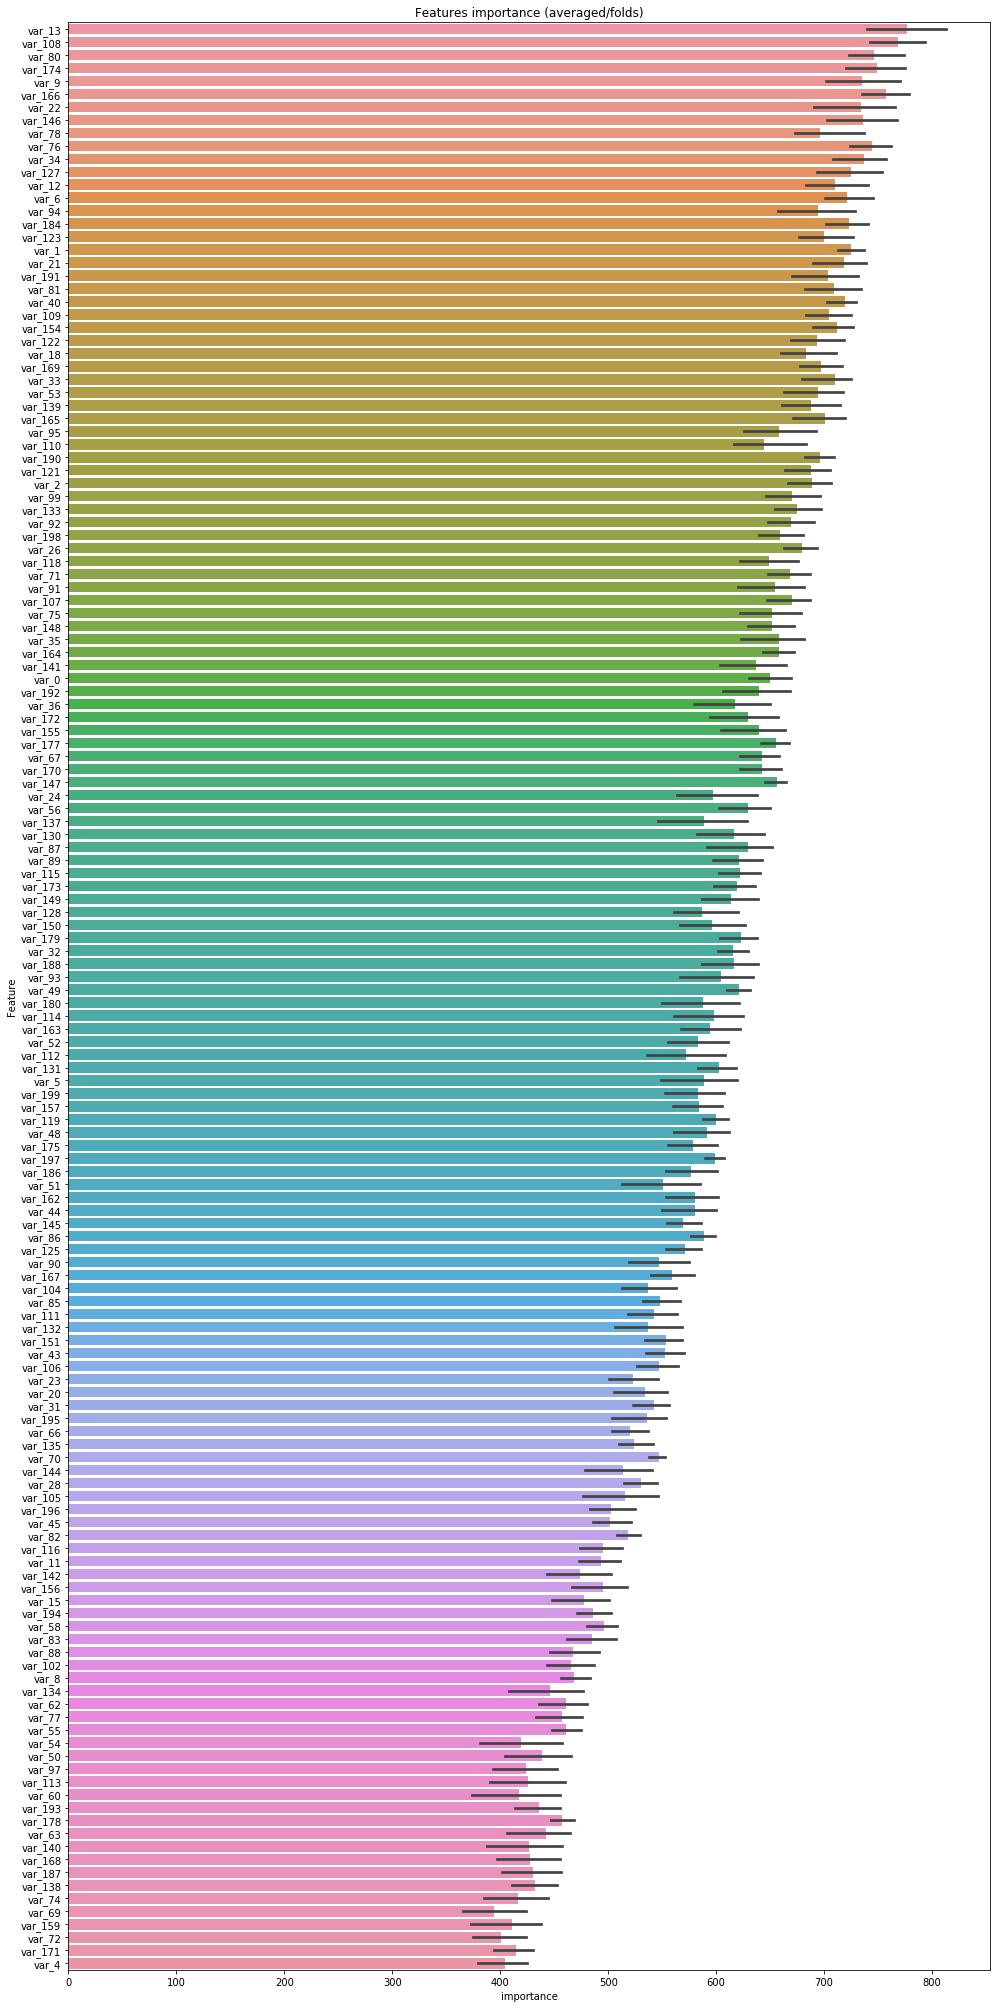

In [11]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('../../04_predict_test/241_FI.png')

In [12]:
#結果保存
if (submit_flg ==1 and sampling_flg==0):
    series_oof_preds = pd.Series(data=oof_preds[:,0], name=save_col_name, dtype='float')
    series_oof_preds.to_csv(train_preds_dir,header=True, index=False)

    sample = pd.read_csv(sample_submission_dir)
    sample.target = test_preds[:,0].astype(float)
    sample.ID_code = test_df['ID_code']
    sample.to_csv(test_preds_dir, index=False)
    

In [13]:
pd.set_option('display.max_rows', 500)
feature_importance_df

,Feature,importance,fold
0,Unnamed: 0,285,1
1,var_0,680,1
2,var_1,730,1
3,var_2,697,1
4,var_3,383,1
5,var_4,426,1
6,var_5,606,1
7,var_6,713,1
8,var_7,312,1
9,var_8,496,1
